In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()


x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, y_train = x_train[:30000], y_train[:30000]
x_valid, y_valid = x_test[:3000], y_test[:3000]
x_test, y_test = x_test[3000:], y_test[3000:]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_valid = x_valid.astype('float32')

x_train = x_train / 255.0
x_test = x_test / 255.0
x_valid = x_valid / 255.0

tr_pairs, tr_y = create_pairs_on_set(x_train, y_train)
tv_pairs, tv_y = create_pairs_on_set(x_valid, y_valid)
ts_pairs, ts_y = create_pairs_on_set(x_test, y_test)

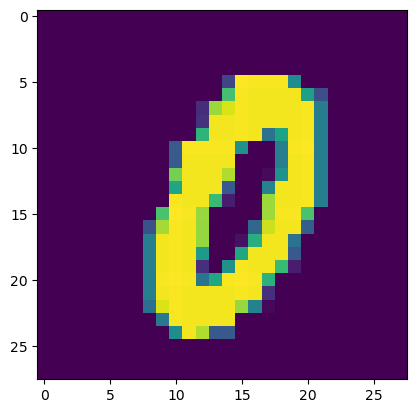

In [ ]:
from matplotlib import pyplot as plt

plt.imshow(tr_pairs[2][1])
plt.show()

In [9]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

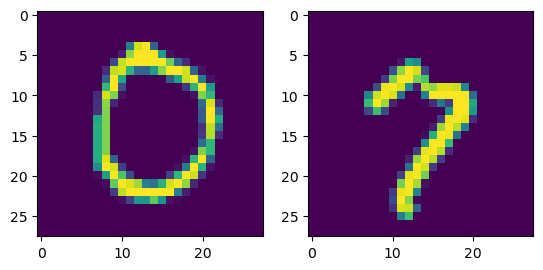

0.0


In [10]:
def show_image_pairs(image_pair):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image_pair[0])
#     ax.colorbar()
    ax[0].grid(False)
    ax[1].imshow(image_pair[1])
#     ax[1].colorbar()
    ax[1].grid(False)
    
    plt.show()

this_pair = 9

show_image_pairs(ts_pairs[this_pair])
print(ts_y[this_pair])

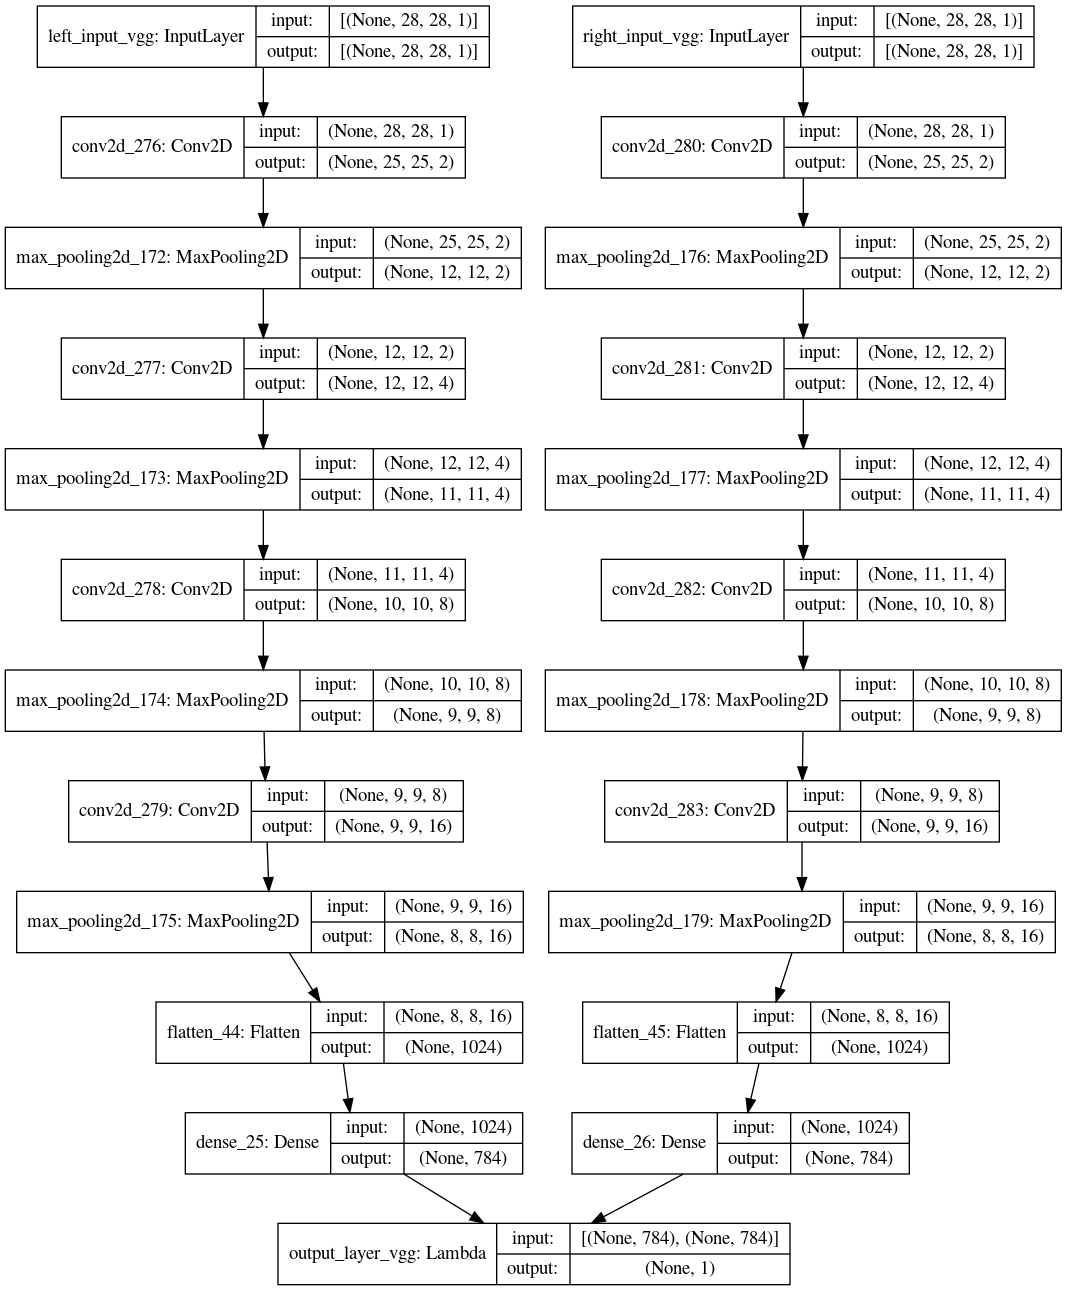

In [66]:
def short_vgg(input_layer):
    in_vgg = input_layer
    div = 32

    x = Conv2D(input_shape=(28,28,1),filters=64//div,kernel_size=((4,4)),padding="valid", activation="relu")(in_vgg)

#     x = Conv2D(filters=64//div,kernel_size=((2,2)),padding="valid", activation="relu")(x)
    x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
    x = Conv2D(filters=128//div, kernel_size=((1,1)), padding="same", activation="relu")(x)

#     x = Conv2D(filters=128//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2,2),strides=(1,1))(x)
    x = Conv2D(filters=256//div, kernel_size=((2,2)), padding="valid", activation="relu")(x)

    #     x = Conv2D(filters=256//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
#     x = Conv2D(filters=256//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
    x = MaxPool2D(pool_size=(2,2),strides=(1,1))(x)
    x = Conv2D(filters=512//div, kernel_size=((2,2)), padding="same", activation="relu")(x)

    #     x = Conv2D(filters=512//16, kernel_size=((1,1)), padding="same", activation="relu")(x)
#     x = Conv2D(filters=512//16, kernel_size=((1,1)), padding="same", activation="relu")(x)

    x = MaxPool2D(pool_size=(2,2),strides=(1,1))(x)
    x = Flatten()(x)
    x = Dense(28*28)(x)

#     vgg_model = Model(inputs=in_vgg, outputs=x)
    return x

# plot_model(vgg_model, show_shapes=True, show_layer_names=True, to_file='outer-model_vgg.png', dpi=300)
input_a_vgg = Input(shape=(28,28,1), name="left_input_vgg")
vect_output_a_vgg = short_vgg(input_a_vgg)

# create the right input and point to the base network
input_b_vgg = Input(shape=(28,28,1), name="right_input_vgg")
vect_output_b_vgg = short_vgg(input_b_vgg)

# measure the similarity of the two vector outputs
output_vgg = Lambda(euclidean_distance, name="output_layer_vgg", output_shape=eucl_dist_output_shape)([vect_output_a_vgg, vect_output_b_vgg])

# specify the inputs and output of the model
model_vgg = Model([input_a_vgg, input_b_vgg], output_vgg)

# plot model graph
plot_model(model_vgg, show_shapes=True, show_layer_names=True, to_file='outer-siamese-model_vgg.png')

In [52]:
    
# # Add a customized layer to compute the absolute difference between the encodings
# L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
# L1_distance = L1_layer([vect_output_a_vgg, vect_output_b_vgg])

# # Add a dense layer with a sigmoid unit to generate the similarity score
# prediction = Dense(1,activation='sigmoid')(L1_distance)

# # Connect the inputs with the outputs
# model_vgg = Model(inputs=[input_a_vgg,input_b_vgg],outputs=prediction)
# plot_model(model_vgg, show_shapes=True, show_layer_names=True, to_file='outer-siamese-model_vgg.png')

In [67]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss


es = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

adam = keras.optimizers.Adam()
rms = keras.optimizers.RMSprop()

model_vgg.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=adam)
history = model_vgg.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=10, validation_data=([tv_pairs[:,0], tv_pairs[:,1]], tv_y),
                       callbacks=es, verbose=1)

n_epochs = len(history.history['loss'])

Epoch 1/10
1136/1693 [===================>..........] - ETA: 6s - loss: 0.5464

KeyboardInterrupt: 

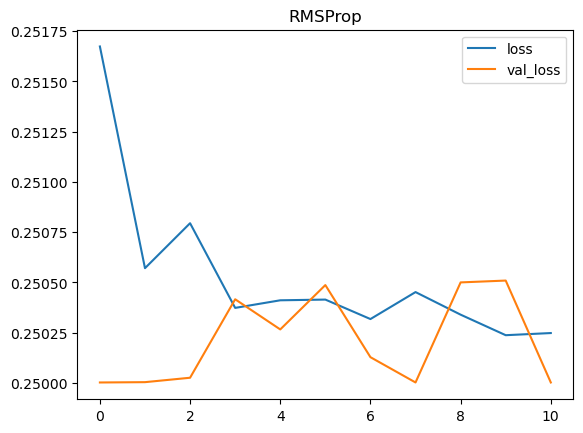

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('RMSProp')
plt.legend()
plt.show()

In [30]:
import pandas as pd

fig = plt.figure(figsize=(14,6))

ax1 = fig.add_subplot(121)
ax1.plot(history.history['loss'], label='loss')
ax1.plot(history.history['val_loss'], label='val_loss')
ax1.legend()
ax1.set_title('RMSprop optimizer')
results_predict = model_vgg.predict([ts_pairs[:,0], ts_pairs[:,1]])
acc = compute_accuracy(ts_y, results_predict)
dfxx = pd.DataFrame(columns=['Accuracy', 'Patience', 'N epochs', 'Training loss', 'Validation loss', 'Train size', 'Test size'], index=[1],
                    data=np.array([np.around(acc, 4), 10, n_epochs, np.around(history.history['loss'][-1], 4), 
                                   np.around(history.history['val_loss'][-1], 4), int(x_train.shape[0]), int(x_test.shape[0])]).reshape(-1,1).T)

ax2 = fig.add_subplot(122)
font_size=10
bbox=[-0.1, 0.25, 1.2, 0.5]
ax2.axis('off')
mpl_table = ax2.table(cellText = dfxx.values, rowLabels = [''], bbox=bbox, colLabels=dfxx.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
# plt.show()
plt.tight_layout()
plt.savefig('table_vgg_rms_1.png', dpi=200)
print()

In [28]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)
compute_accuracy(ts_y, results_predict)


0.5013157894736842

### X_train shape: 20.000
### X_test shape: 3.000
### Patience: 3
#### Adam optimizer: 0.9475925925925925
#### RMSProp: 0.9466666666666667

### Patience: 5
#### Adam optimizer: 0.9511111111111111
#### RMSProp: 0.9507407407407408

